# **----- Import Libraries -----**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import re
import urllib
import html
import ast
import string
import pythainlp

from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

from gensim.models import LdaModel  # LDA
from gensim.corpora.dictionary import Dictionary  # for count words and create dictionary

# **----- Load Data from Pantip -----**

In [2]:
df_youtube_comment_suicide_labeled = pd.read_excel('../output - final/df_youtube_comment_suicide_labeled.xlsx')

# **----- Prep Data from Pantip -----**

## Prep Data for Classification Modeling

In [3]:
# check dataframe column and data type
print(df_youtube_comment_suicide_labeled.dtypes)

videoId            object
title              object
comment            object
date       datetime64[ns]
label               int64
dtype: object


In [4]:
# check dataframe label column value count
df_youtube_comment_suicide_labeled['label'].value_counts()

label
0    12883
2      271
1      206
Name: count, dtype: int64

In [5]:
# create the new column in the dataframe called "sub_label" which transform value from the "label" column with following rule:
# value 0 = 0
# value 1 = 11
# value 2 = 12

# Mapping values from the 'label' column to new values for the 'sub_label' column
label_mapping1 = {0: 0, 1: 11, 2: 12}

# Creating the new column 'sub_label' with transformed values
df_youtube_comment_suicide_labeled['sub_label'] = df_youtube_comment_suicide_labeled['label'].map(label_mapping1)

# Display the DataFrame
print(df_youtube_comment_suicide_labeled['sub_label'].value_counts())


sub_label
0     12883
12      271
11      206
Name: count, dtype: int64


In [6]:
# transform the current column 'label with following rules 
# 0 to 0 
# 1 to 1 
# 2 to 1


# Mapping old values from the 'label' column to new values for the 'label' column
label_mapping2 = {0: 0, 1: 1, 2: 1}

# Creating the new column 'sub_label' with transformed values
df_youtube_comment_suicide_labeled['label'] = df_youtube_comment_suicide_labeled['label'].map(label_mapping2)

# Display the DataFrame
print(df_youtube_comment_suicide_labeled['label'].value_counts())

label
0    12883
1      477
Name: count, dtype: int64


In [7]:
# recheck dataframe column and data type
print(df_youtube_comment_suicide_labeled.dtypes)

videoId              object
title                object
comment              object
date         datetime64[ns]
label                 int64
sub_label             int64
dtype: object


In [8]:
# check NaN 
df_youtube_comment_suicide_labeled.isnull().sum()

# we will not use title so we will not drop column

videoId       0
title        78
comment       0
date          0
label         0
sub_label     0
dtype: int64

In [9]:
# remove non useful characters, tokensize text, and remove stopword and single thai alphabets on comment column

def integrated_preprocess_tokenize(text):
    # Check if text is not a string
    if not isinstance(text, str):
        return []

    ### Preprocessing ###
    text = html.unescape(urllib.parse.unquote(text))  # Unicode and URL decoding
    text = re.sub(r'https?.+?(?:\s|$)', '', text)  # Remove URLs
    text = re.sub(r'[""„\"]', '', text)  # Remove double quotations
    text = re.sub(r'[''′′′′`\']', '', text)  # Remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text)  # Shrink whitespaces
    text = re.sub(r'[\r\u200b\ufeff]+', '', text)  # Remove non-breaking space
    text = re.sub(r'เเ', 'แ', text)  # Correct common misspelling
    text = re.sub(r'(า)า+|(ย)ย+|(ๆ)ๆ+|(ะ)ะ+', r'\1', text)
    text = re.sub(r'ํา','ำ', text)  # Correct character combination
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text)  # Adjust tone marks

    ### Tokenization ###
    tokens = word_tokenize(text, keep_whitespace=False)

    ### Remove Stopwords and Single Thai Alphabets ###
    stopwords = thai_stopwords()
    tokens = [token for token in tokens if token 
              not in stopwords 
              and re.match(r'[A-zก-ไ][A-zก-๙\.]*', token)
              ]

    return tokens

# Applying the integrated function to the DataFrame
df_youtube_comment_suicide_labeled['tokenized_text'] = df_youtube_comment_suicide_labeled['comment'].apply(integrated_preprocess_tokenize)

# Display the new 'tokenized_text' column
print(df_youtube_comment_suicide_labeled['tokenized_text'])

0                                                 [ขอบคุณ]
1        [อย่า, ยึด, ติดกับ, ความดี, ตีเส้น, ตัวเอง, เค...
2                                                 [ขอบคุณ]
3                               [ฟัง, อีฟ, เหมือน, อ่านใจ]
4                                                 [ขอบคุณ]
                               ...                        
13355    [ความเบื่อ, ฮี, ล, ใจ, แรงบันดาลใจ, การทำงาน, ...
13356    [เบื่อ, ไร้, ทิศทาง, รู้, หันหน้า, เครียด, หมด...
13357    [ว่างเปล่า, ทำ, ทำ, มีความรู้สึก, ผิดหวัง, ตัว...
13358    [จังหวัด, ที่อยู่, หา, จิตแพทย์, รักษา, รพ., เ...
13359    [ผม, ทรมาน, ปี, เลิกกัน, อาการ, เหมือน, โดน, ท...
Name: tokenized_text, Length: 13360, dtype: object


In [10]:
# remove words specific to youtube comment data and additional stopwords 

# List of strings to remove
strings_to_remove = ["Alljit", "<br>", "&quot;", "a", "br", "href", "ฟัง", "ขอบคุณ"
    "เเต่", "เค้า", "ปี", "ตอนนี้", "นะคะ", "กิน", "แบบนี้", "เวลา", "ไหม", "คน", "ดี",
    "เเล้ว", "หนู", "เดือน", "ตอนนั้น", "นะครับ", "ทำ", "แบบนั้น", "เมื่อไร", "อาการ", "ไม่ดี",
    "เพราะ", "ผม", "วัน", "คะ", "รู้สึก", "ตอนไหน", "เรื่อง",
    "เมือ", "คุณ", "สัปดาห์", "ครับ", "ถาม", "ไหน",
    "เหมือน", "เธอ", "อาทิตย์", "ชอบ", "อะไร",
    "มัน", "โดน", "รู้", "มึง", "กู", "เรา", "ชั้น", "ฉัน", "เย", "วัส", 'แล้', 'วจะ'
]

def preprocess_and_clean_text2(tokens:list):
    return [token for token in tokens if token not in strings_to_remove]

# Apply the function to the 'all_text' column
df_youtube_comment_suicide_labeled['tokenized_text'] = df_youtube_comment_suicide_labeled['tokenized_text'].apply(preprocess_and_clean_text2)
# Display the new 'tokenized_text' column
df_youtube_comment_suicide_labeled['tokenized_text']  

0                                                 [ขอบคุณ]
1        [อย่า, ยึด, ติดกับ, ความดี, ตีเส้น, ตัวเอง, เค...
2                                                 [ขอบคุณ]
3                                            [อีฟ, อ่านใจ]
4                                                 [ขอบคุณ]
                               ...                        
13355    [ความเบื่อ, ฮี, ล, ใจ, แรงบันดาลใจ, การทำงาน, ...
13356    [เบื่อ, ไร้, ทิศทาง, หันหน้า, เครียด, หมดหวัง,...
13357    [ว่างเปล่า, มีความรู้สึก, ผิดหวัง, ตัวเอง, เฉย...
13358    [จังหวัด, ที่อยู่, หา, จิตแพทย์, รักษา, รพ., เ...
13359    [ทรมาน, เลิกกัน, ทิ้ง, โดดเดี่ยว, ตามลำพัง, มี...
Name: tokenized_text, Length: 13360, dtype: object

In [11]:
# Convert the 'time' column to datetime
df_youtube_comment_suicide_labeled['date'] = pd.to_datetime(df_youtube_comment_suicide_labeled['date'])

# Extract the time column into day of week, day of month, month of year, and year
df_youtube_comment_suicide_labeled['day_week'] = df_youtube_comment_suicide_labeled['date'].dt.day_name()
df_youtube_comment_suicide_labeled['day_month'] = df_youtube_comment_suicide_labeled['date'].dt.day
df_youtube_comment_suicide_labeled['month_year'] = df_youtube_comment_suicide_labeled['date'].dt.month_name()
df_youtube_comment_suicide_labeled['year'] = df_youtube_comment_suicide_labeled['date'].dt.year

In [12]:
# Extract the time column into time of day

# Converting the 'time' column to datetime
df_youtube_comment_suicide_labeled['date'] = pd.to_datetime(df_youtube_comment_suicide_labeled['date'])

# Function to categorize time into the specified ranges
def categorize_time(time):
    if time.hour < 3:
        return '0-3'
    elif time.hour < 6:
        return '3-6'
    elif time.hour < 9:
        return '6-9'
    elif time.hour < 12:
        return '9-12'
    elif time.hour < 15:
        return '12-15'
    elif time.hour < 18:
        return '15-18'
    elif time.hour < 21:
        return '18-21'
    else:
        return '21-24'

# Applying the function to create a new column
df_youtube_comment_suicide_labeled['time_day'] = df_youtube_comment_suicide_labeled['date'].apply(lambda x: categorize_time(x))

# show result 
df_youtube_comment_suicide_labeled['time_day'].value_counts()

time_day
21-24    3005
18-21    2168
0-3      1611
12-15    1553
9-12     1535
15-18    1488
6-9      1234
3-6       766
Name: count, dtype: int64

In [13]:
# create the title length column, text length column, title emoji check column, text emoji check column 

# Function to detect emojis
def contains_emoji(s):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(s))

# Creating the columns
df_youtube_comment_suicide_labeled['text_len'] = df_youtube_comment_suicide_labeled['comment'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df_youtube_comment_suicide_labeled['text_emoji'] = df_youtube_comment_suicide_labeled['comment'].apply(lambda x: 1 if isinstance(x, str) and contains_emoji(x) else 0)


In [14]:
#check NaN
df_youtube_comment_suicide_labeled.isnull().sum()

videoId            0
title             78
comment            0
date               0
label              0
sub_label          0
tokenized_text     0
day_week           0
day_month          0
month_year         0
year               0
time_day           0
text_len           0
text_emoji         0
dtype: int64

## Save Data to CSV for Classification Modeling

In [15]:
# check newly created columns and categorize features into group to use later 
print(df_youtube_comment_suicide_labeled.columns)

Index(['videoId', 'title', 'comment', 'date', 'label', 'sub_label',
       'tokenized_text', 'day_week', 'day_month', 'month_year', 'year',
       'time_day', 'text_len', 'text_emoji'],
      dtype='object')


In [16]:
# save the dataframe df_pantip_posts_suicide_labeled to csv under the name df_pantip_posts_suicide_labeled_processed.csv
df_youtube_comment_suicide_labeled.to_csv('../output - final/df_youtube_comment_suicide_labeled_processed.csv')

# **----- Do EDA & Visualization -----**

## Target label analysis

### 0 = no suicide ideation vs 1 = suicide ideation

In [17]:
# check % frequency of target label suicide ideation vs no suicidie ideation
print(df_youtube_comment_suicide_labeled['label'].value_counts(normalize=True))
print(df_youtube_comment_suicide_labeled['sub_label'].value_counts(normalize=True))


label
0    0.964296
1    0.035704
Name: proportion, dtype: float64
sub_label
0     0.964296
12    0.020284
11    0.015419
Name: proportion, dtype: float64


## Time feature analysis

### Day of week

In [38]:
df_youtube_comment_suicide_labeled['day_week'].value_counts(normalize = True)

day_week
Wednesday    0.150150
Monday       0.148802
Tuesday      0.143862
Thursday     0.142515
Friday       0.142141
Sunday       0.136302
Saturday     0.136228
Name: proportion, dtype: float64

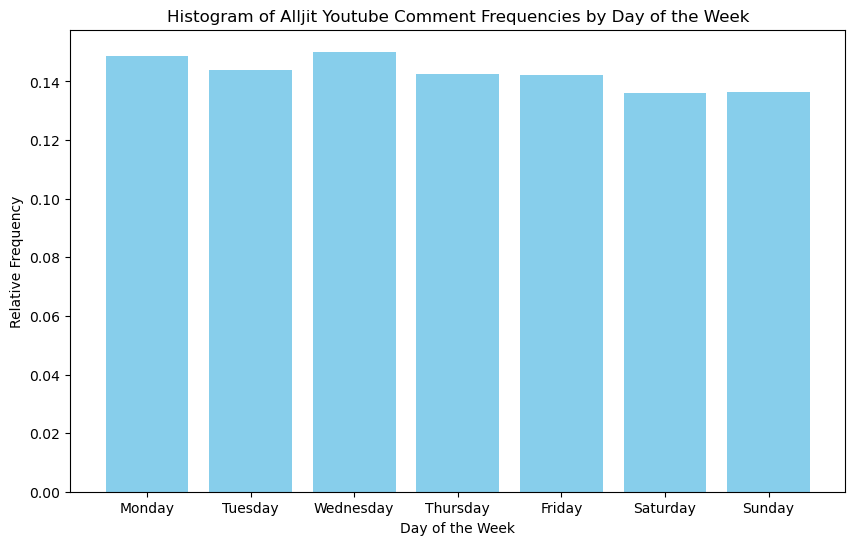

In [44]:
# Extracting value counts and converting to relative frequencies
day_week_counts = df_youtube_comment_suicide_labeled['day_week'].value_counts(normalize=True)

# Creating a DataFrame from the day_week_counts
df_day_week = pd.DataFrame({'Day': day_week_counts.index, 'Frequency': day_week_counts.values})

# Ordering the DataFrame by day of the week
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_day_week['Day'] = pd.Categorical(df_day_week['Day'], categories=order, ordered=True)
df_day_week = df_day_week.sort_values('Day')

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(df_day_week['Day'], df_day_week['Frequency'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Alljit Youtube Comment Frequencies by Day of the Week')
plt.show()

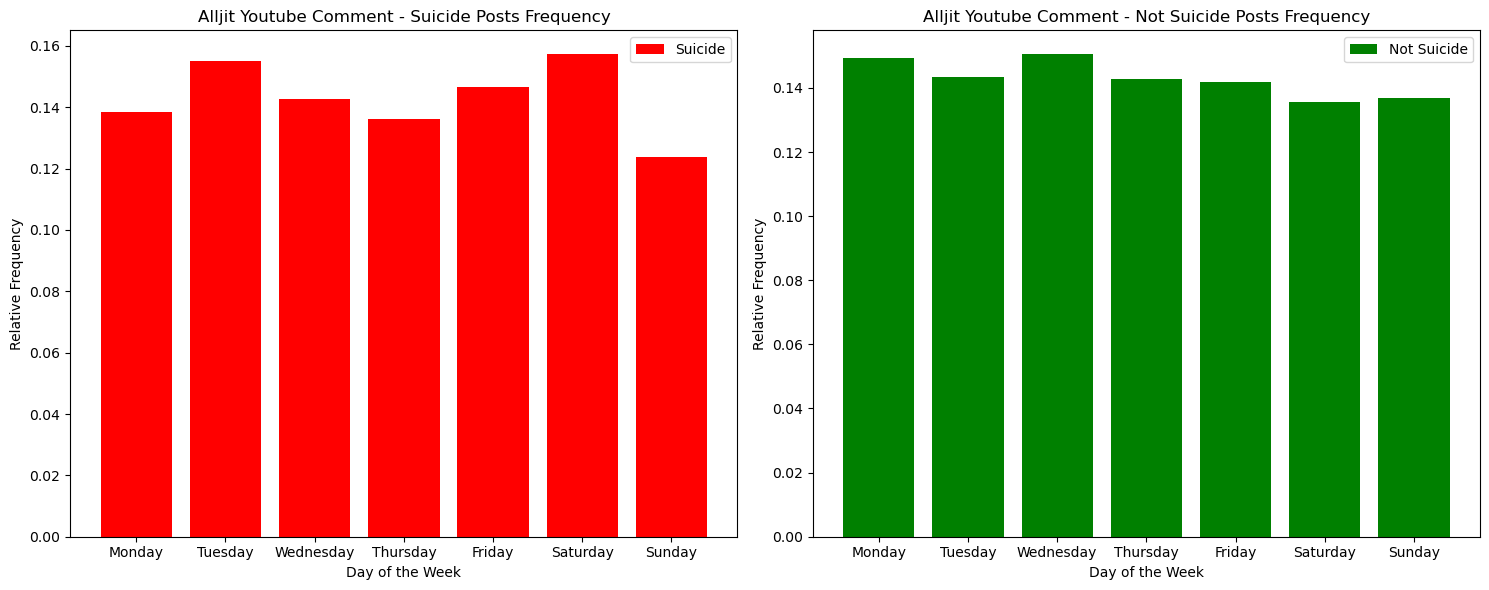

In [45]:
# Separate the data based on the 'label' values
suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]
not_suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['day_week'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['day_week'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Day': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Day': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by day of the week
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_suicide['Day'] = pd.Categorical(df_suicide['Day'], categories=order, ordered=True)
df_suicide = df_suicide.sort_values('Day')
df_not_suicide['Day'] = pd.Categorical(df_not_suicide['Day'], categories=order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('Day')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Day'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Alljit Youtube Comment - Suicide Posts Frequency')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Relative Frequency')
axes[0].legend()

axes[1].bar(df_not_suicide['Day'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Alljit Youtube Comment - Not Suicide Posts Frequency')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Relative Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

### Day of month

In [42]:
df_youtube_comment_suicide_labeled['day_month'].value_counts(normalize = True)

day_month
6     0.041467
12    0.036751
19    0.036527
5     0.036377
2     0.035329
11    0.034132
7     0.033982
10    0.033907
14    0.033608
28    0.033234
30    0.033159
8     0.033159
1     0.032859
3     0.032859
27    0.032560
26    0.032260
15    0.032186
13    0.032186
20    0.032111
29    0.032111
25    0.031886
9     0.031437
4     0.031437
18    0.030240
23    0.030090
16    0.029716
17    0.029491
22    0.028518
21    0.028368
24    0.027919
31    0.020135
Name: proportion, dtype: float64

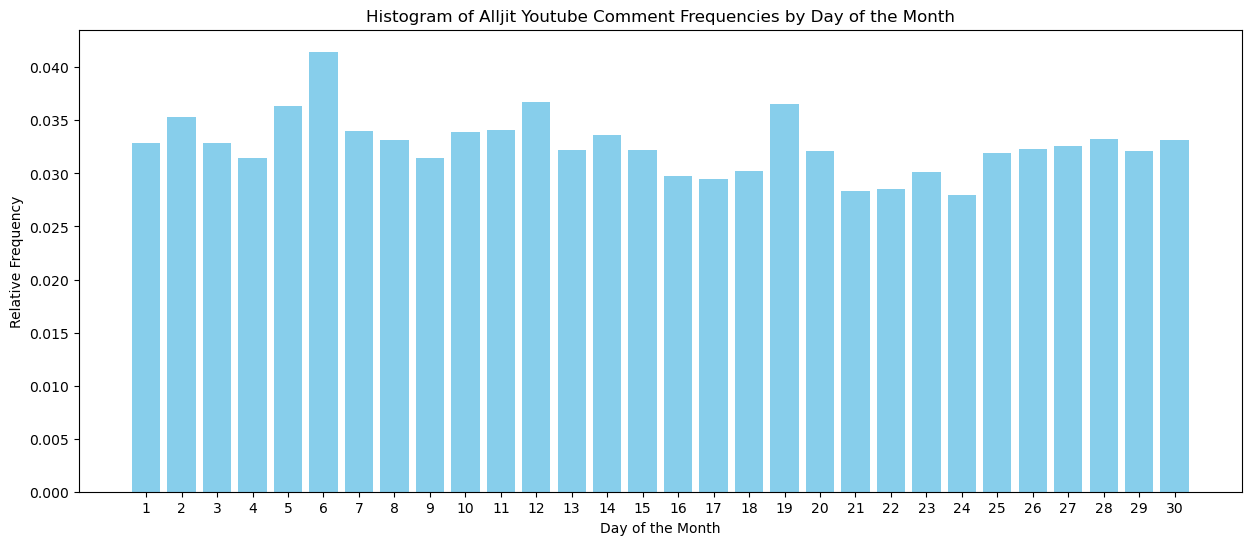

In [43]:
# Extracting value counts and converting to relative frequencies for the 'day_month' column
day_month_counts = df_youtube_comment_suicide_labeled['day_month'].value_counts(normalize=True)

# Creating a DataFrame from the day_month_counts
df_day_month = pd.DataFrame({'Day': day_month_counts.index, 'Frequency': day_month_counts.values})

# Ordering the DataFrame by day of the month
order = list(range(1, 31))  # Days from 1 to 30
df_day_month['Day'] = pd.Categorical(df_day_month['Day'], categories=order, ordered=True)
df_day_month = df_day_month.sort_values('Day')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_day_month['Day'], df_day_month['Frequency'], color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Alljit Youtube Comment Frequencies by Day of the Month')
plt.xticks(order)  # To ensure all days are displayed on the x-axis
plt.show()

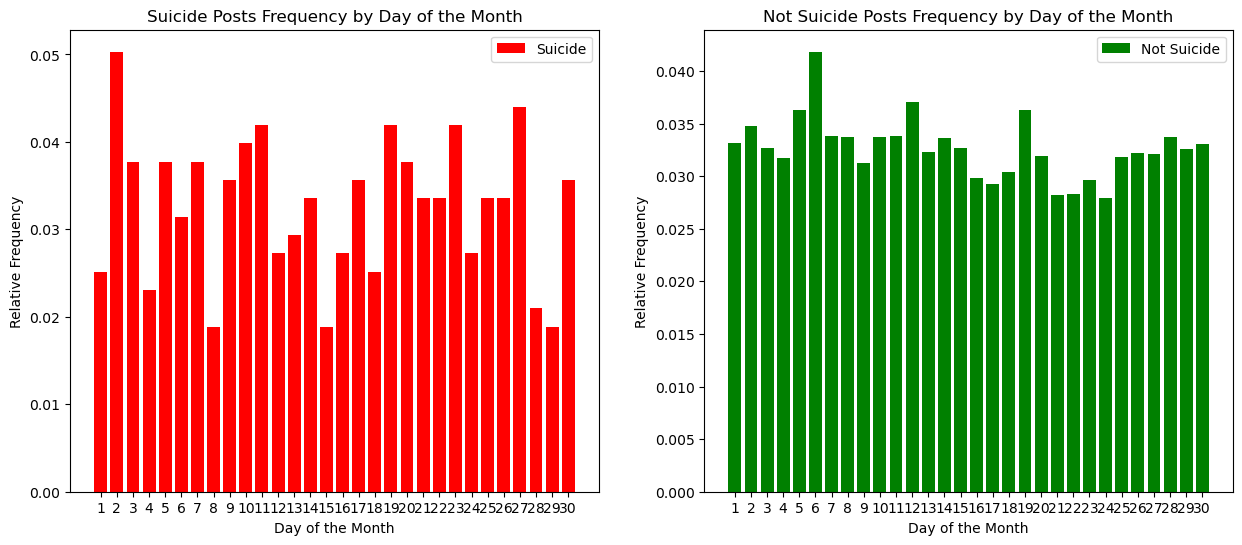

In [46]:
# Separate the data based on the 'label' values
suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]
not_suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies
suicide_counts = suicide_posts['day_month'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['day_month'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Day': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Day': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by day of the month
order = list(range(1, 31))  # Days from 1 to 30
df_suicide['Day'] = pd.Categorical(df_suicide['Day'], categories=order, ordered=True)
df_suicide = df_suicide.sort_values('Day')
df_not_suicide['Day'] = pd.Categorical(df_not_suicide['Day'], categories=order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('Day')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Day'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Day of the Month')
axes[0].set_xlabel('Day of the Month')
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xticks(order)
axes[0].legend()

axes[1].bar(df_not_suicide['Day'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Day of the Month')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xticks(order)
axes[1].legend()

### Month of year

In [47]:
df_youtube_comment_suicide_labeled['month_year'].value_counts(normalize = True)

month_year
September    0.147904
October      0.138024
August       0.132784
July         0.107410
November     0.107111
June         0.065344
December     0.057485
May          0.057260
January      0.051123
April        0.048428
February     0.046781
March        0.040344
Name: proportion, dtype: float64

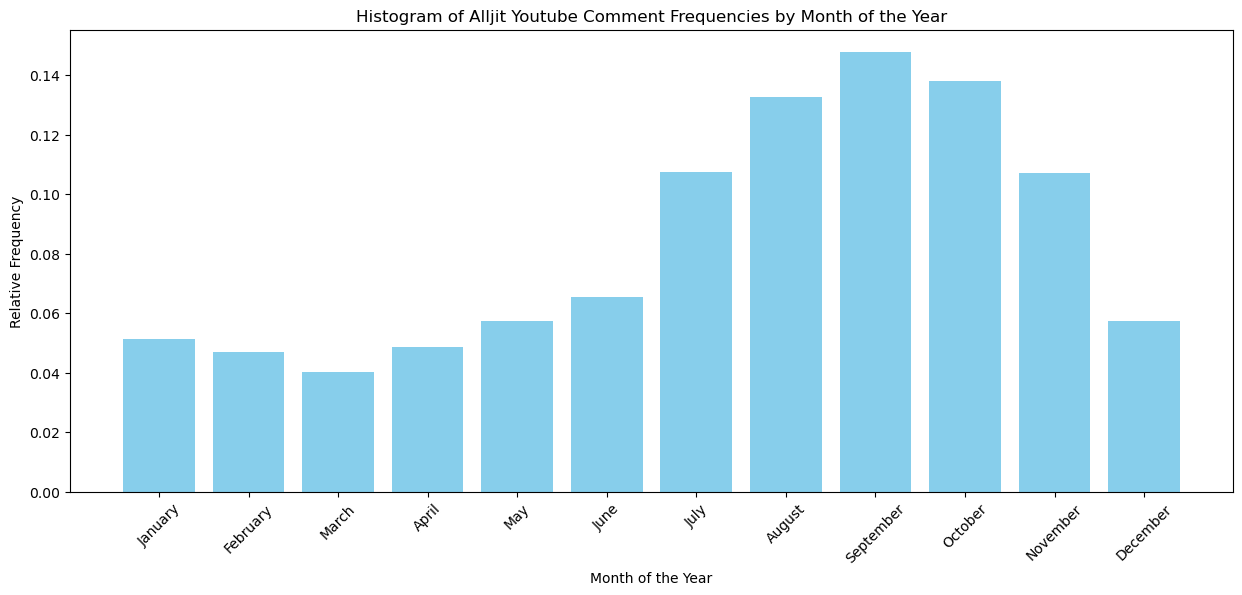

In [48]:
# Extracting value counts and converting to relative frequencies for the 'month_year' column
month_year_counts = df_youtube_comment_suicide_labeled['month_year'].value_counts(normalize=True)

# Creating a DataFrame from the month_year_counts
df_month_year = pd.DataFrame({'Month': month_year_counts.index, 'Frequency': month_year_counts.values})

# Ordering the DataFrame by month
order = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 'December']
df_month_year['Month'] = pd.Categorical(df_month_year['Month'], categories=order, ordered=True)
df_month_year = df_month_year.sort_values('Month')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_month_year['Month'], df_month_year['Frequency'], color='skyblue')
plt.xlabel('Month of the Year')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Alljit Youtube Comment Frequencies by Month of the Year')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

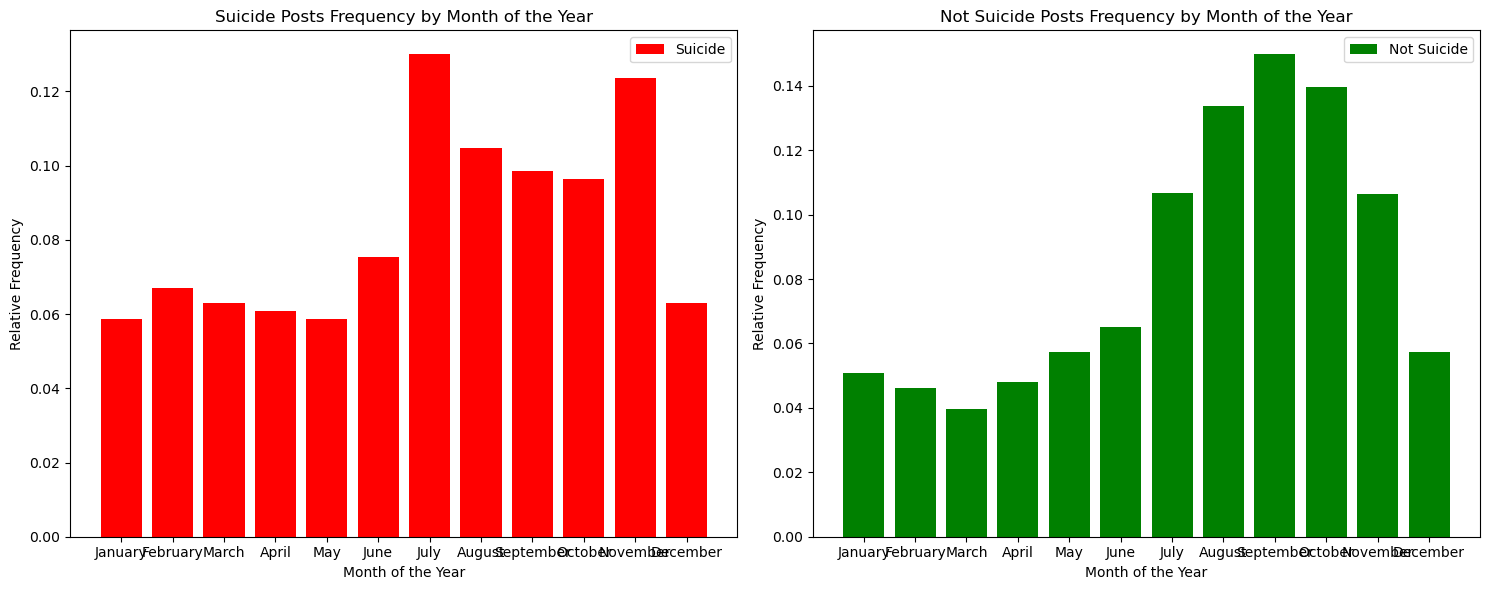

In [49]:
# Separate the data based on the 'label' values
suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]
not_suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['month_year'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['month_year'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Month': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Month': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by month of the year
order = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 'December']
df_suicide['Month'] = pd.Categorical(df_suicide['Month'], categories=order, ordered=True)
df_suicide = df_suicide.sort_values('Month')
df_not_suicide['Month'] = pd.Categorical(df_not_suicide['Month'], categories=order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('Month')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Month'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Month of the Year')
axes[0].set_xlabel('Month of the Year')
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xticks(order)
axes[0].legend()

axes[1].bar(df_not_suicide['Month'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Month of the Year')
axes[1].set_xlabel('Month of the Year')
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xticks(order)
axes[1].legend()

plt.tight_layout()
plt.show()

### Time of day

In [50]:
df_youtube_comment_suicide_labeled['time_day'].value_counts(normalize = True)

time_day
21-24    0.224925
18-21    0.162275
0-3      0.120584
12-15    0.116243
9-12     0.114895
15-18    0.111377
6-9      0.092365
3-6      0.057335
Name: proportion, dtype: float64

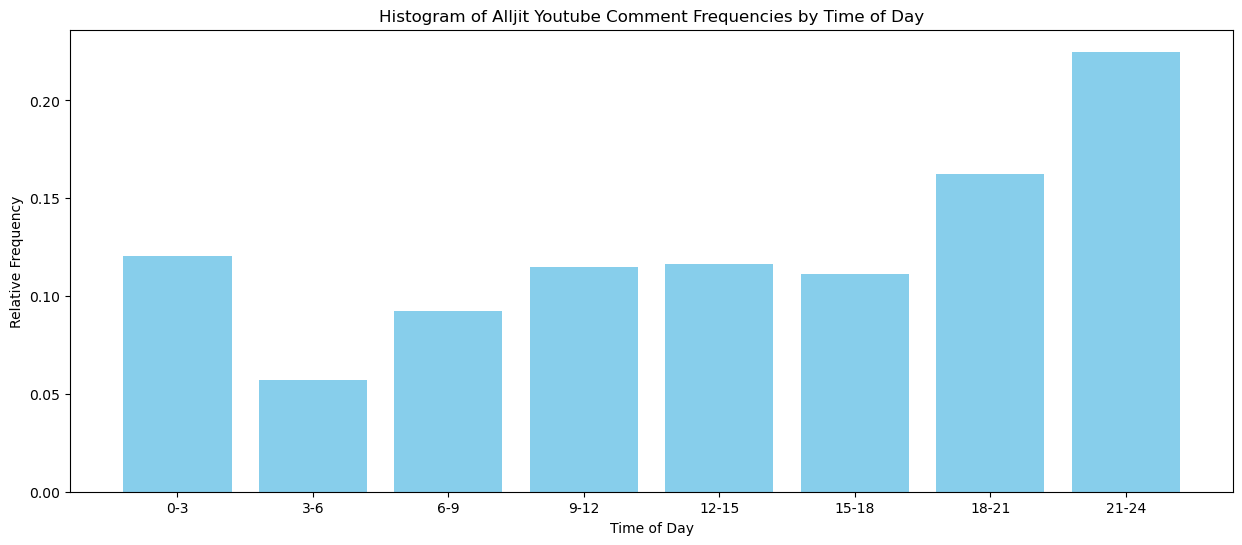

In [51]:
# Extracting value counts and converting to relative frequencies for the 'time_day' column
time_day_counts = df_youtube_comment_suicide_labeled['time_day'].value_counts(normalize=True)

# Creating a DataFrame from the time_day_counts
df_time_day = pd.DataFrame({'TimeRange': time_day_counts.index, 'Frequency': time_day_counts.values})

# Ordering the DataFrame by time ranges
time_order = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
df_time_day['TimeRange'] = pd.Categorical(df_time_day['TimeRange'], categories=time_order, ordered=True)
df_time_day = df_time_day.sort_values('TimeRange')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_time_day['TimeRange'], df_time_day['Frequency'], color='skyblue')
plt.xlabel('Time of Day')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Alljit Youtube Comment Frequencies by Time of Day')
plt.xticks(time_order)  # Ensure all time ranges are displayed on the x-axis
plt.show()

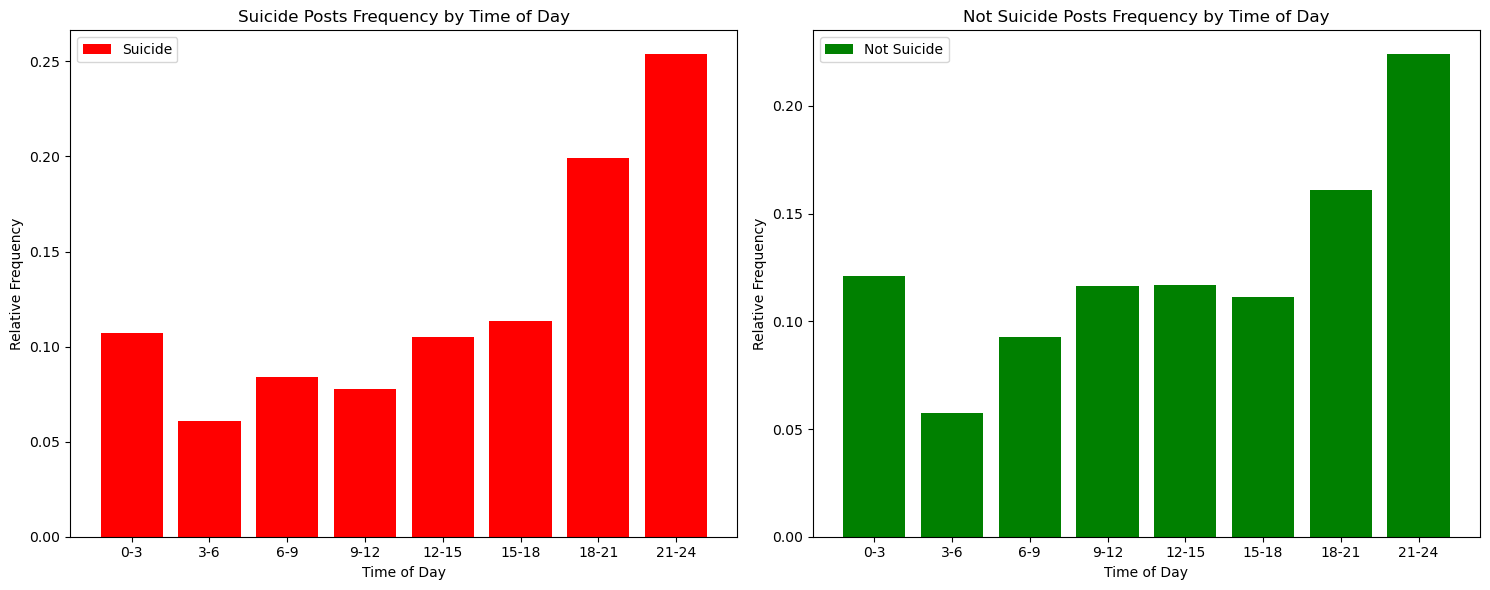

In [52]:
# Separate the data based on the 'label' values
suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]
not_suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['time_day'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['time_day'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'TimeRange': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'TimeRange': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by time of day
time_order = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
df_suicide['TimeRange'] = pd.Categorical(df_suicide['TimeRange'], categories=time_order, ordered=True)
df_suicide = df_suicide.sort_values('TimeRange')
df_not_suicide['TimeRange'] = pd.Categorical(df_not_suicide['TimeRange'], categories=time_order, ordered=True)
df_not_suicide = df_not_suicide.sort_values('TimeRange')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['TimeRange'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Time of Day')
axes[0].set_xlabel('Time of Day')
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xticks(time_order)
axes[0].legend()

axes[1].bar(df_not_suicide['TimeRange'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Time of Day')
axes[1].set_xlabel('Time of Day')
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xticks(time_order)
axes[1].legend()

plt.tight_layout()
plt.show()

### Year

In [53]:
df_youtube_comment_suicide_labeled['year'].value_counts(normalize = True)

year
2022    0.537350
2023    0.345135
2021    0.117515
Name: proportion, dtype: float64

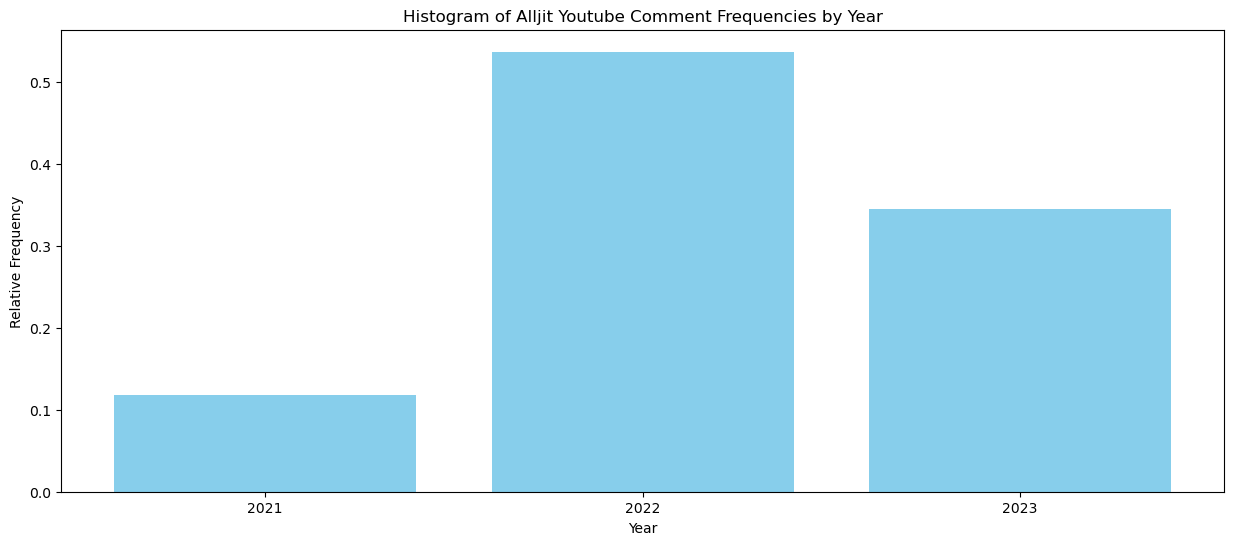

In [54]:

# Extracting value counts and converting to relative frequencies for the 'year' column
year_counts = df_youtube_comment_suicide_labeled['year'].value_counts(normalize=True)

# Creating a DataFrame from the year_counts
df_year = pd.DataFrame({'Year': year_counts.index, 'Frequency': year_counts.values})

# Ordering the DataFrame by year
df_year = df_year.sort_values('Year')

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(df_year['Year'], df_year['Frequency'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Alljit Youtube Comment Frequencies by Year')
plt.xticks(df_year['Year'])  # Ensure all years are displayed on the x-axis
plt.show()

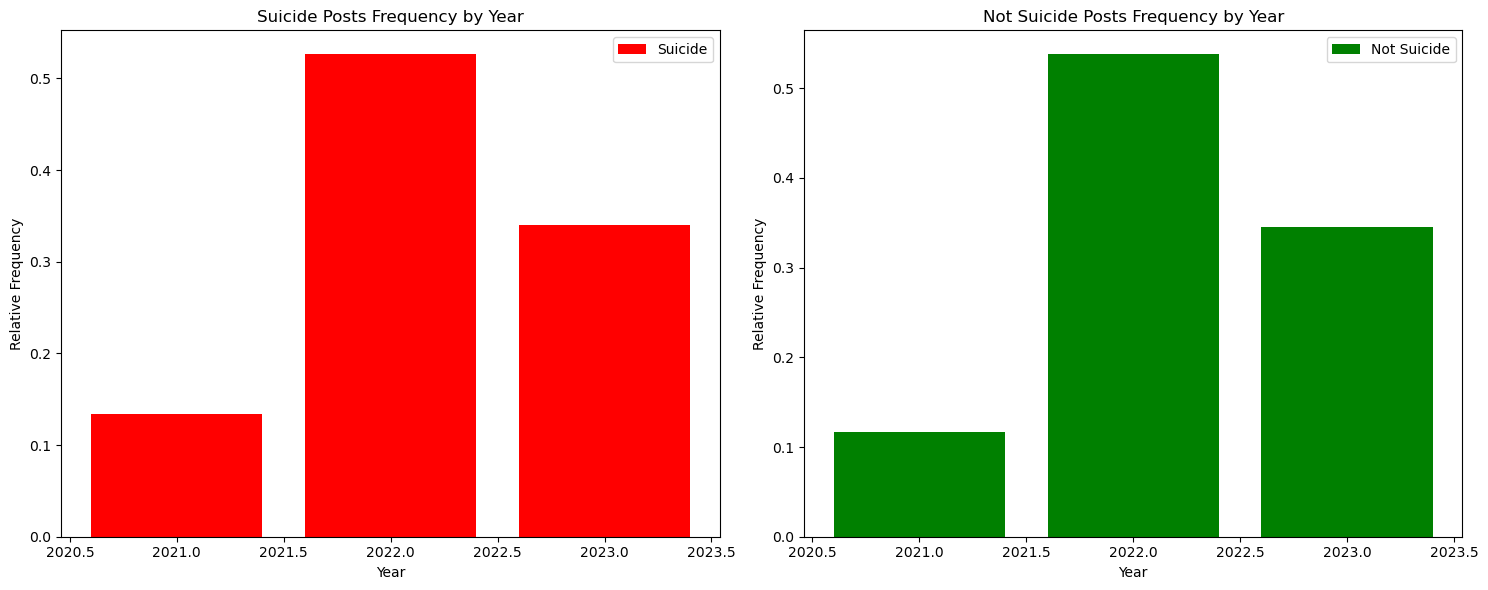

In [56]:
# Separate the data based on the 'label' values
suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]
not_suicide_posts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]

# Getting value counts and converting to relative frequencies for each label
suicide_counts = suicide_posts['year'].value_counts(normalize=True)
not_suicide_counts = not_suicide_posts['year'].value_counts(normalize=True)

# Creating DataFrames for plotting
df_suicide = pd.DataFrame({'Year': suicide_counts.index, 'Frequency': suicide_counts.values})
df_not_suicide = pd.DataFrame({'Year': not_suicide_counts.index, 'Frequency': not_suicide_counts.values})

# Ordering the DataFrames by year
df_suicide = df_suicide.sort_values('Year')
df_not_suicide = df_not_suicide.sort_values('Year')

# Plotting the histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(df_suicide['Year'], df_suicide['Frequency'], color='red', label='Suicide')
axes[0].set_title('Suicide Posts Frequency by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Relative Frequency')
axes[0].legend()

axes[1].bar(df_not_suicide['Year'], df_not_suicide['Frequency'], color='green', label='Not Suicide')
axes[1].set_title('Not Suicide Posts Frequency by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Relative Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

## Text numeric feature analysis

### Length of text

In [57]:
df_youtube_comment_suicide_labeled['text_len'].value_counts(normalize = True)

text_len
10      0.013698
13      0.009731
12      0.009132
1       0.008982
9       0.008982
          ...   
618     0.000075
1004    0.000075
1698    0.000075
1963    0.000075
707     0.000075
Name: proportion, Length: 969, dtype: float64

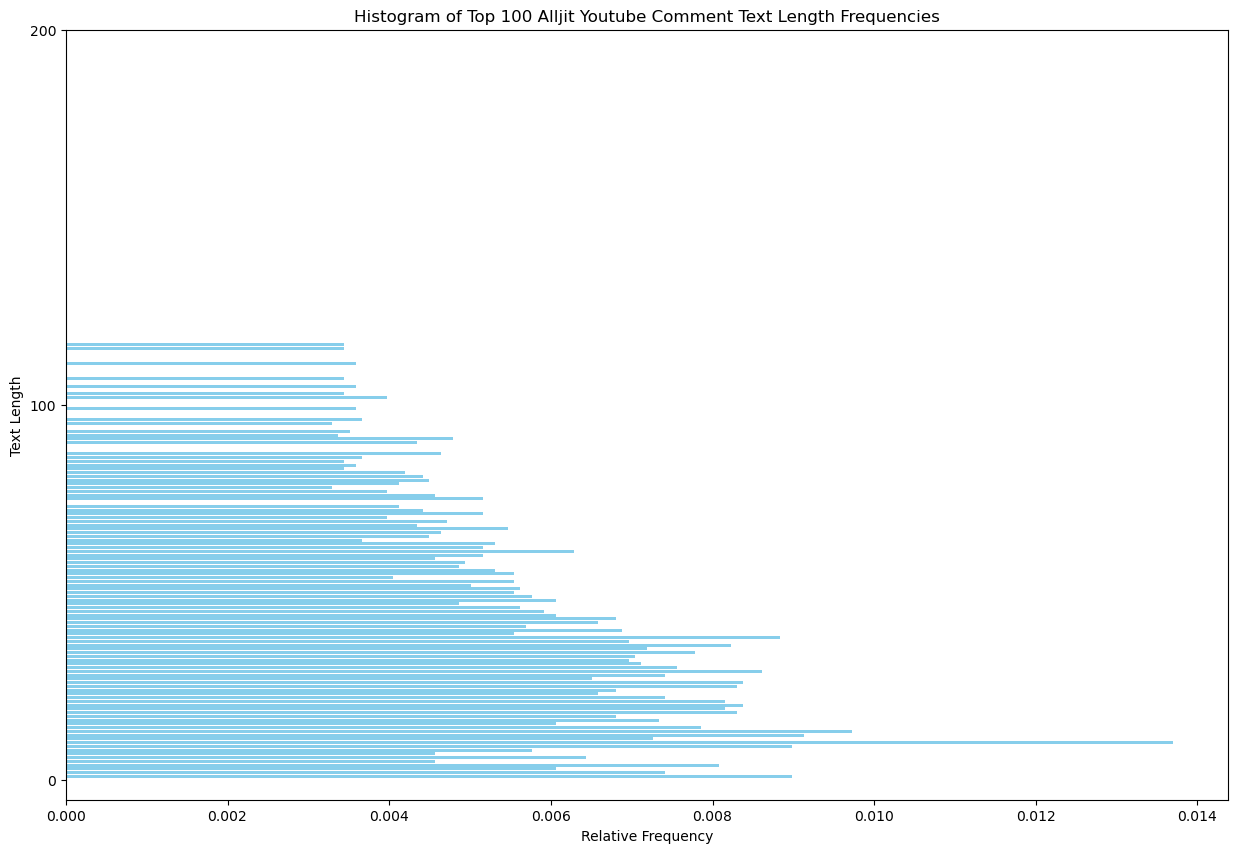

In [59]:
# Extracting value counts and converting to relative frequencies for the 'text_len' column
text_len_counts = df_youtube_comment_suicide_labeled['text_len'].value_counts(normalize=True)

# Creating a DataFrame from the text_len_counts
df_text_len = pd.DataFrame({'Text Length': text_len_counts.index, 'Frequency': text_len_counts.values})

# Sorting the DataFrame by Frequency and selecting the top 100 values
df_text_len = df_text_len.sort_values('Frequency', ascending=False).head(100)

# Re-sorting the selected DataFrame by Text Length
df_text_len = df_text_len.sort_values('Text Length')

# Plotting the horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(df_text_len['Text Length'], df_text_len['Frequency'], color='skyblue')
plt.ylabel('Text Length')
plt.xlabel('Relative Frequency')
plt.title('Histogram of Top 100 Alljit Youtube Comment Text Length Frequencies')
plt.yticks(np.arange(0, max(df_text_len['Text Length']) + 100, 100))  # Adjusting y-axis ticks
plt.xticks(fontsize=10)  # Smaller font for x-axis ticks

plt.show()

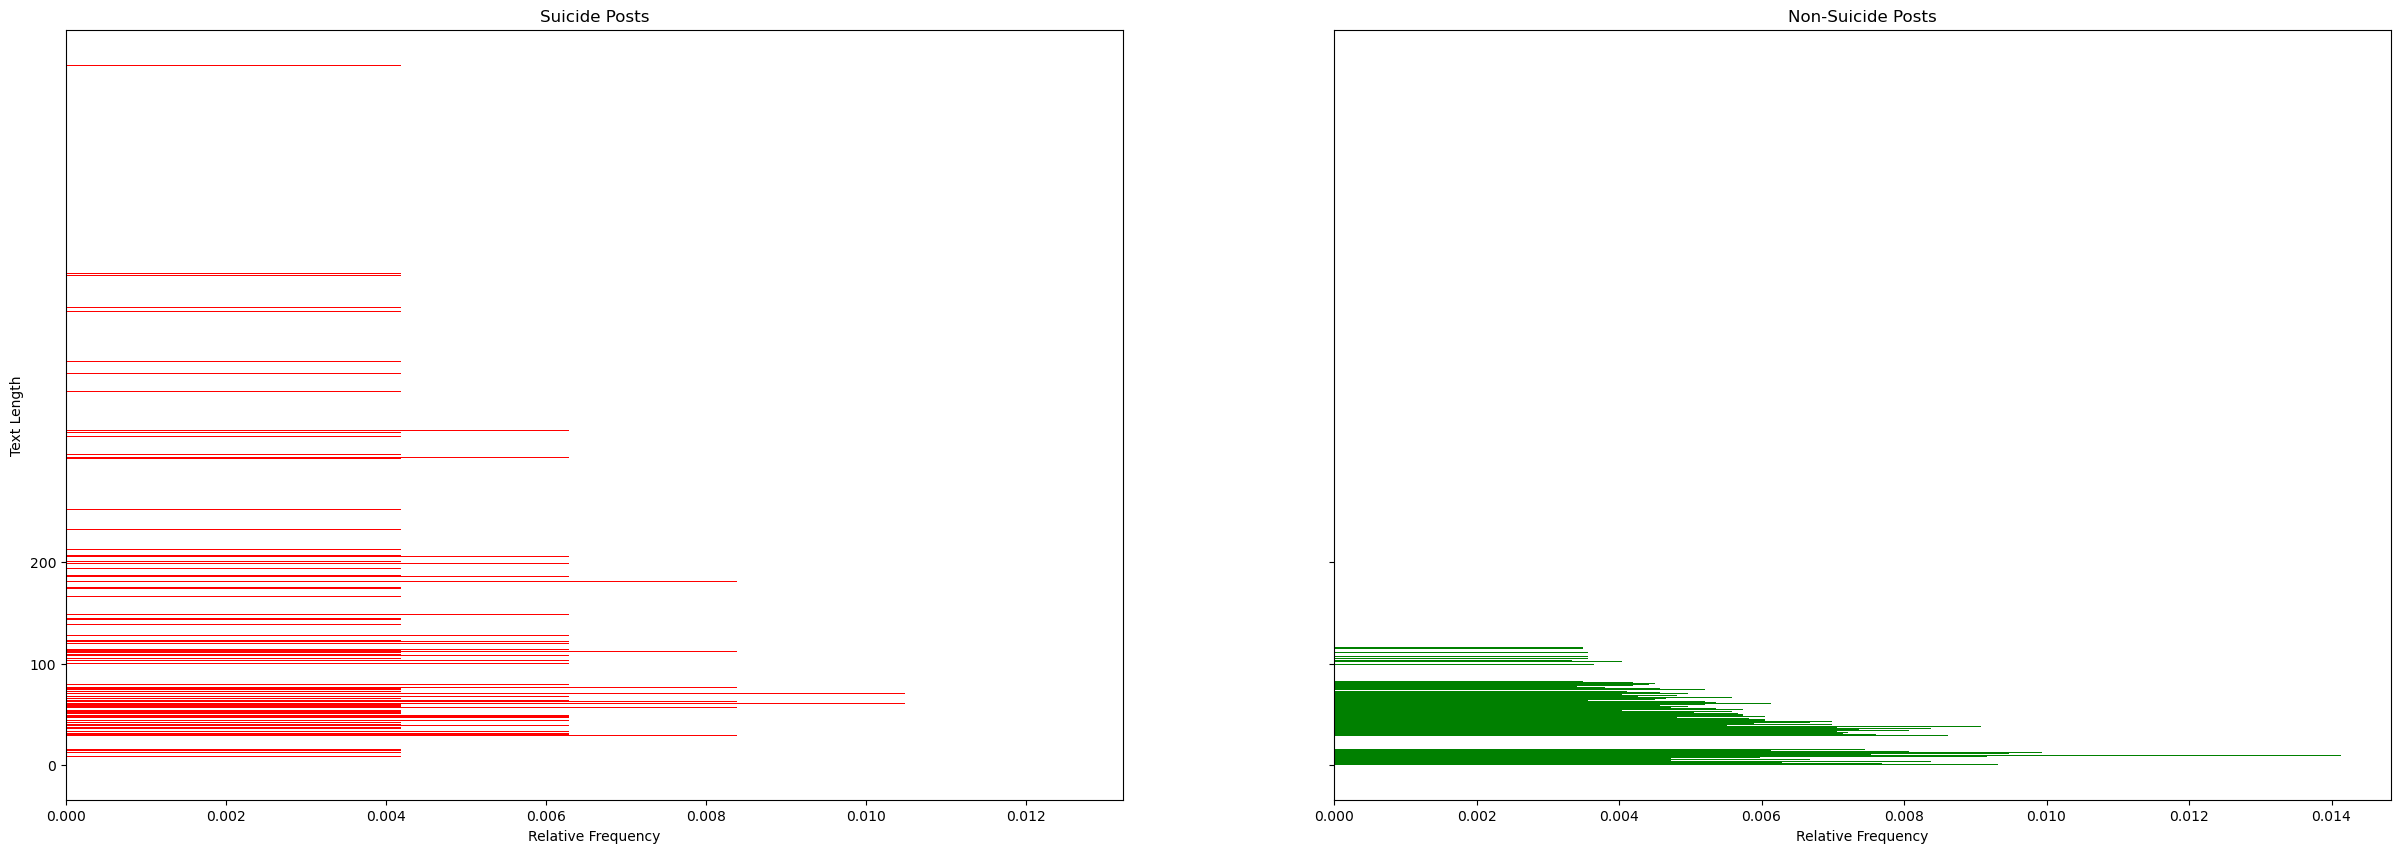

In [60]:
# Extracting value counts for each label and converting to relative frequencies
text_len_counts_label_1 = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]['text_len'].value_counts(normalize=True)
text_len_counts_label_0 = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]['text_len'].value_counts(normalize=True)

# Creating DataFrames from the counts
df_text_len_label_1 = pd.DataFrame({'Text Length': text_len_counts_label_1.index, 'Frequency': text_len_counts_label_1.values})
df_text_len_label_0 = pd.DataFrame({'Text Length': text_len_counts_label_0.index, 'Frequency': text_len_counts_label_0.values})

# Sorting the DataFrames by Frequency and selecting the top 100 values, then re-sorting by Text Length
df_text_len_label_1 = df_text_len_label_1.sort_values('Frequency', ascending=False).head(100).sort_values('Text Length')
df_text_len_label_0 = df_text_len_label_0.sort_values('Frequency', ascending=False).head(100).sort_values('Text Length')

# Setting up the plot
fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey=True)

# Plotting the chart for label 1 (suicide)
axes[0].barh(df_text_len_label_1['Text Length'], df_text_len_label_1['Frequency'], color='red')
axes[0].set_title('Suicide Posts')
axes[0].set_xlabel('Relative Frequency')
axes[0].set_ylabel('Text Length')
axes[0].set_yticks(np.arange(0, max(df_text_len_label_1['Text Length']) + 100, 100))  # Adjusting y-axis ticks

# Plotting the chart for label 0 (not suicide)
axes[1].barh(df_text_len_label_0['Text Length'], df_text_len_label_0['Frequency'], color='green')
axes[1].set_title('Non-Suicide Posts')
axes[1].set_xlabel('Relative Frequency')
axes[1].set_yticks(np.arange(0, max(df_text_len_label_0['Text Length']) + 100, 100))  # Adjusting y-axis ticks

plt.show()

In [61]:
print('Suicide Ideation')
print(df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]['text_len'].describe())
print('\n')
print('Non Suicide Ideation')
print(df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]['text_len'].describe())

Suicide Ideation
count     477.000000
mean      300.714885
std       427.684299
min         9.000000
25%        69.000000
50%       162.000000
75%       336.000000
max      3485.000000
Name: text_len, dtype: float64


Non Suicide Ideation
count    12883.000000
mean       148.116665
std        222.110517
min          1.000000
25%         33.000000
50%         78.000000
75%        176.000000
max       3626.000000
Name: text_len, dtype: float64


## Text category feature analysis 

### Emoji check on text 

In [111]:
df_youtube_comment_suicide_labeled['text_emoji'].value_counts(normalize=True)

text_emoji
0    0.906352
1    0.093648
Name: proportion, dtype: float64

In [62]:
print('Suicide Ideation')
print(df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]['text_emoji'].value_counts(normalize=True))
print('\n')
print('Non Suicide Ideation')
print(df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]['text_emoji'].value_counts(normalize=True))

Suicide Ideation
text_emoji
0    0.798742
1    0.201258
Name: proportion, dtype: float64


Non Suicide Ideation
text_emoji
0    0.79275
1    0.20725
Name: proportion, dtype: float64


In [63]:
# categorize features into group to use later 

time_category_features = ['day_week', 'day_month', 'month_year', 'year', 'time_day']
text_numeric_feature = ['text_len']
text_category_features = ['text_emoji']

In [64]:
# do the correlation matrix between target "label" and features such as time features, numerical text features, categorical text features 
df_for_correlation = df_youtube_comment_suicide_labeled[['label'] + time_category_features + text_numeric_feature + text_category_features]

# **----- Do the Topical Modeling -----**

## Define data sets for topical modeling
We will to do 3 groups of topical modeling  including 

        - depression topical modeling, which use all rows of all_text column
        - suicide ideation topical modeling, which use only row label ==1 of all_text column
        - non suicide ideation topical modeling, which use only row label ==0of all_text

In [75]:
# remove keyword text from tokenized_text before LDA

# # List of strings to remove
strings_to_remove2 = ["ซึมเศร้า", "ฆ่าตัวตาย", "ตาย"]

def preprocess_and_clean_text3(tokens:list):
    return [token for token in tokens if token not in strings_to_remove2]

# Apply the function to the 'all_text' column
df_youtube_comment_suicide_labeled['tokenized_text'] = df_youtube_comment_suicide_labeled['tokenized_text'].apply(preprocess_and_clean_text3)
# Display the new 'tokenized_text' column
df_youtube_comment_suicide_labeled['tokenized_text'] 

# Define the datasets
mental_health_texts = df_youtube_comment_suicide_labeled['tokenized_text']
suicide_ideation_texts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 1]['tokenized_text']
non_suicide_ideation_texts = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['label'] == 0]['tokenized_text']

active_sucide_ideation_text = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['sub_label'] == 11]['tokenized_text']
passive_sucide_ideation_text = df_youtube_comment_suicide_labeled[df_youtube_comment_suicide_labeled['sub_label'] == 12]['tokenized_text']


## Alljit Youtube Comment - "Mental Health" topical modeling

In [77]:
## create vocab <> ID dictionary
dictionary = Dictionary(mental_health_texts) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in mental_health_texts]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
เหนื่อย | นอน | หาย | ยา | ตื่น | รัก | แฟน | ฝัน | หมอ | พี่ | หลับ | ตัวเอง | เสียง | ร้องไห้ | ทรมาน | ดู | ลูก | ตอน | รักษา | ดีขึ้น 

---------- TOPIC 1 ----------
คนเดียว | ตัวเอง | เพื่อน | คุย | ขอบคุณ | บ้าน | แม่ | เจอ | กลัว | ครอบครัว | สังคม | คนอื่น | มีความสุข | ตอน | ทำงาน | ชีวิต | หา | เหนื่อย | นึง | เด็ก 

---------- TOPIC 2 ----------
ตัวเอง | ชีวิต | เจอ | คนอื่น | ใจ | โลก | ดู | ที่จะ | มีความสุข | คนเดียว | เบื่อ | ความคิด | หา | หมอ | ตัว | คุย | ครอบครัว | ทำร้าย | ร้องไห้ | แฟน 



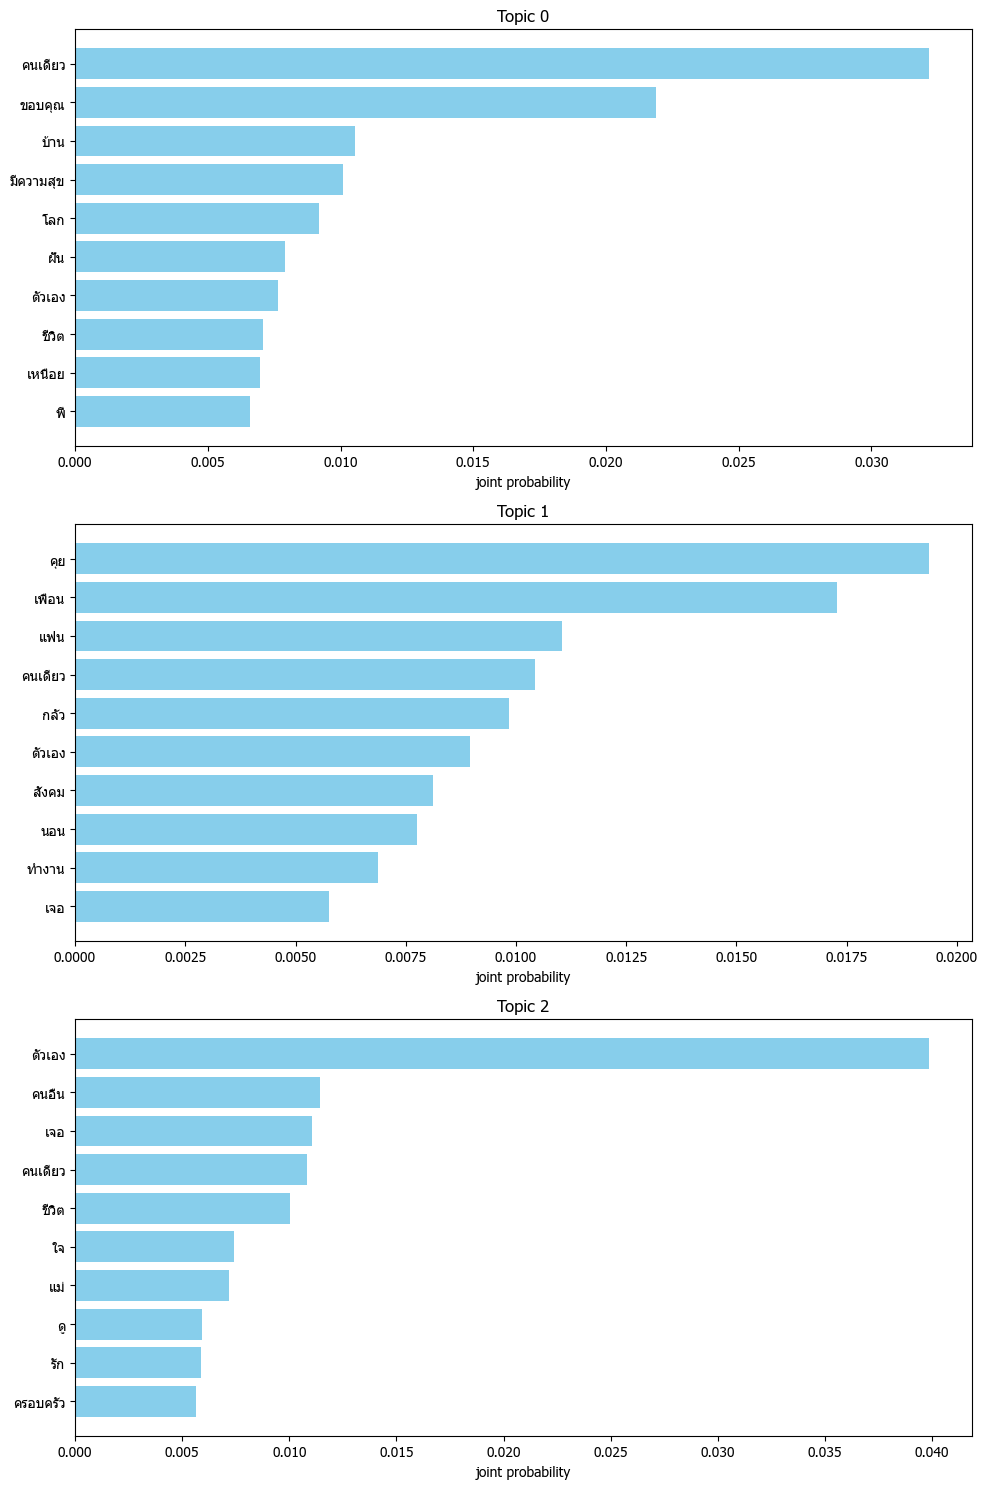

In [97]:

# Set font to one that supports Thai characters
plt.rcParams['font.family'] = 'Tahoma'

def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('joint probability')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Suicide ideation topical modeling

In [79]:
## create vocab <> ID dictionary
dictionary = Dictionary(suicide_ideation_texts) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in suicide_ideation_texts]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
ตัวเอง | แม่ | โลก | ชีวิต | เหนื่อย | ครอบครัว | หาย | หมอ | ยา | บ้าน | เพื่อน | เจอ | ใจ | หา | ดิฉัน | รักษา | คนเดียว | ปัญหา | แย่ | ร้องไห้ 

---------- TOPIC 1 ----------
ตัวเอง | เหนื่อย | หาย | ชีวิต | เจอ | คนเดียว | มีชีวิต | ครอบครัว | นอน | ลูก | ร้องไห้ | พ่อแม่ | บ้าน | โลก | น้อง | ตื่น | แม่ | คนอื่น | หมอ | แย่ 

---------- TOPIC 2 ----------
ตัวเอง | เหนื่อย | ครอบครัว | พ่อแม่ | หาย | แม่ | กลัว | หา | ความคิด | เครียด | ชีวิต | นอน | เจอ | หมอ | เพื่อน | โลก | บ้าน | เบื่อ | ที่จะ | ทำงาน 



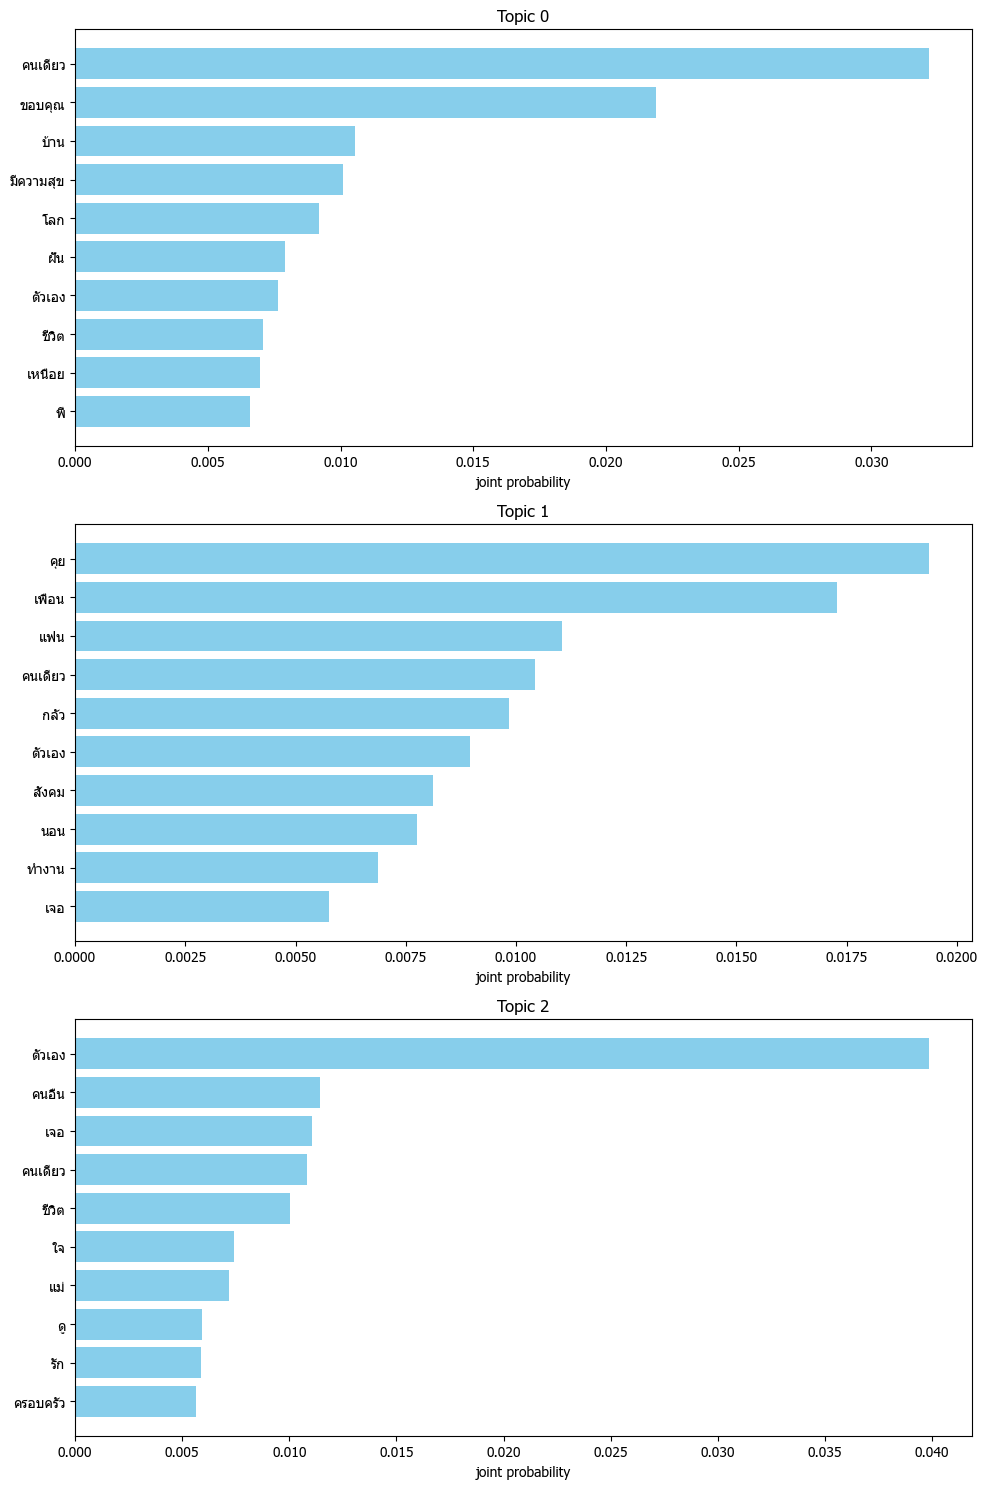

In [93]:
# Set font to one that supports Thai characters
plt.rcParams['font.family'] = 'Tahoma'

def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('joint probability')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Active suicide ideation topical modeling

In [80]:
## create vocab <> ID dictionary
dictionary = Dictionary(active_sucide_ideation_text) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in active_sucide_ideation_text]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
ตัวเอง | หมอ | แม่ | ครอบครัว | บอ | เหนื่อย | ชีวิต | น้อง | เจอ | หา | เครียด | เบื่อ | ยา | คนเดียว | พี่ | เจ็บ | นอน | เงิน | เพื่อน | หาย 

---------- TOPIC 1 ----------
ตัวเอง | ครอบครัว | แม่ | เหนื่อย | ยา | ความคิด | คนเดียว | นอน | กลัว | หาย | ตื่น | ชีวิต | หมอ | บ้าน | ดิฉัน | ลูก | ร้องไห้ | เป็นโรค | ขอบคุณ | พ่อแม่ 

---------- TOPIC 2 ----------
แม่ | ตัวเอง | พ่อแม่ | บ้าน | ทำร้าย | ชีวิต | ไม้ | ยา | เพื่อน | ใจ | เหนื่อย | พ่อ | ที่จะ | ความคิด | ตัว | หมอ | เจอ | กลัว | ครอบครัว | นอน 



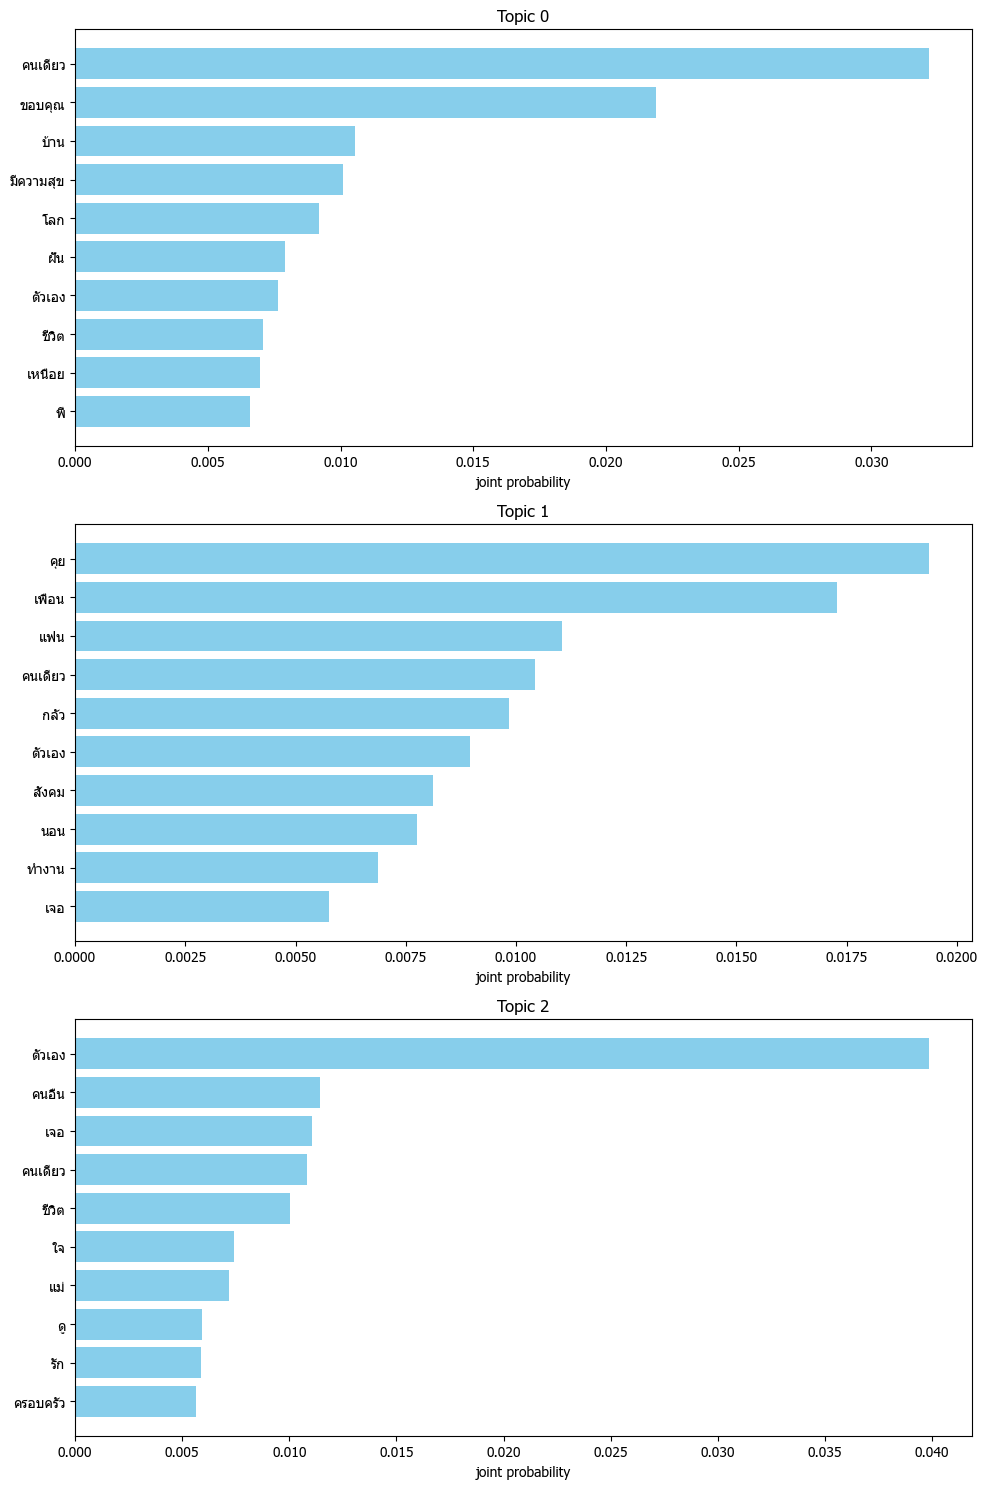

In [94]:
# Set font to one that supports Thai characters
plt.rcParams['font.family'] = 'Tahoma'

def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('joint probability')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Passive suicide ideation topical modeling

In [82]:
## create vocab <> ID dictionary
dictionary = Dictionary(active_sucide_ideation_text) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in active_sucide_ideation_text]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
แม่ | ตัวเอง | หมอ | น้อง | ชีวิต | เหนื่อย | ครอบครัว | ทำร้าย | บอ | แย่ | ยา | ดิฉัน | เจอ | พ่อแม่ | เป็นโรค | นอน | ใจ | ไหว | หา | ทรมาน 

---------- TOPIC 1 ----------
ตัวเอง | พ่อแม่ | เหนื่อย | เบื่อ | แม่ | บ้าน | เพื่อน | กลัว | ยา | หมอ | คนเดียว | ชีวิต | หาย | ลูก | เครียด | คุย | เป็นโรค | ครอบครัว | หา | เจอ 

---------- TOPIC 2 ----------
ตัวเอง | ครอบครัว | ความคิด | ยา | แม่ | ร้องไห้ | ทำร้าย | ชีวิต | นอน | บ้าน | คนเดียว | กลัว | หา | ทำงาน | เครียด | เจอ | พ่อ | ที่จะ | เหนื่อย | ปัญหา 



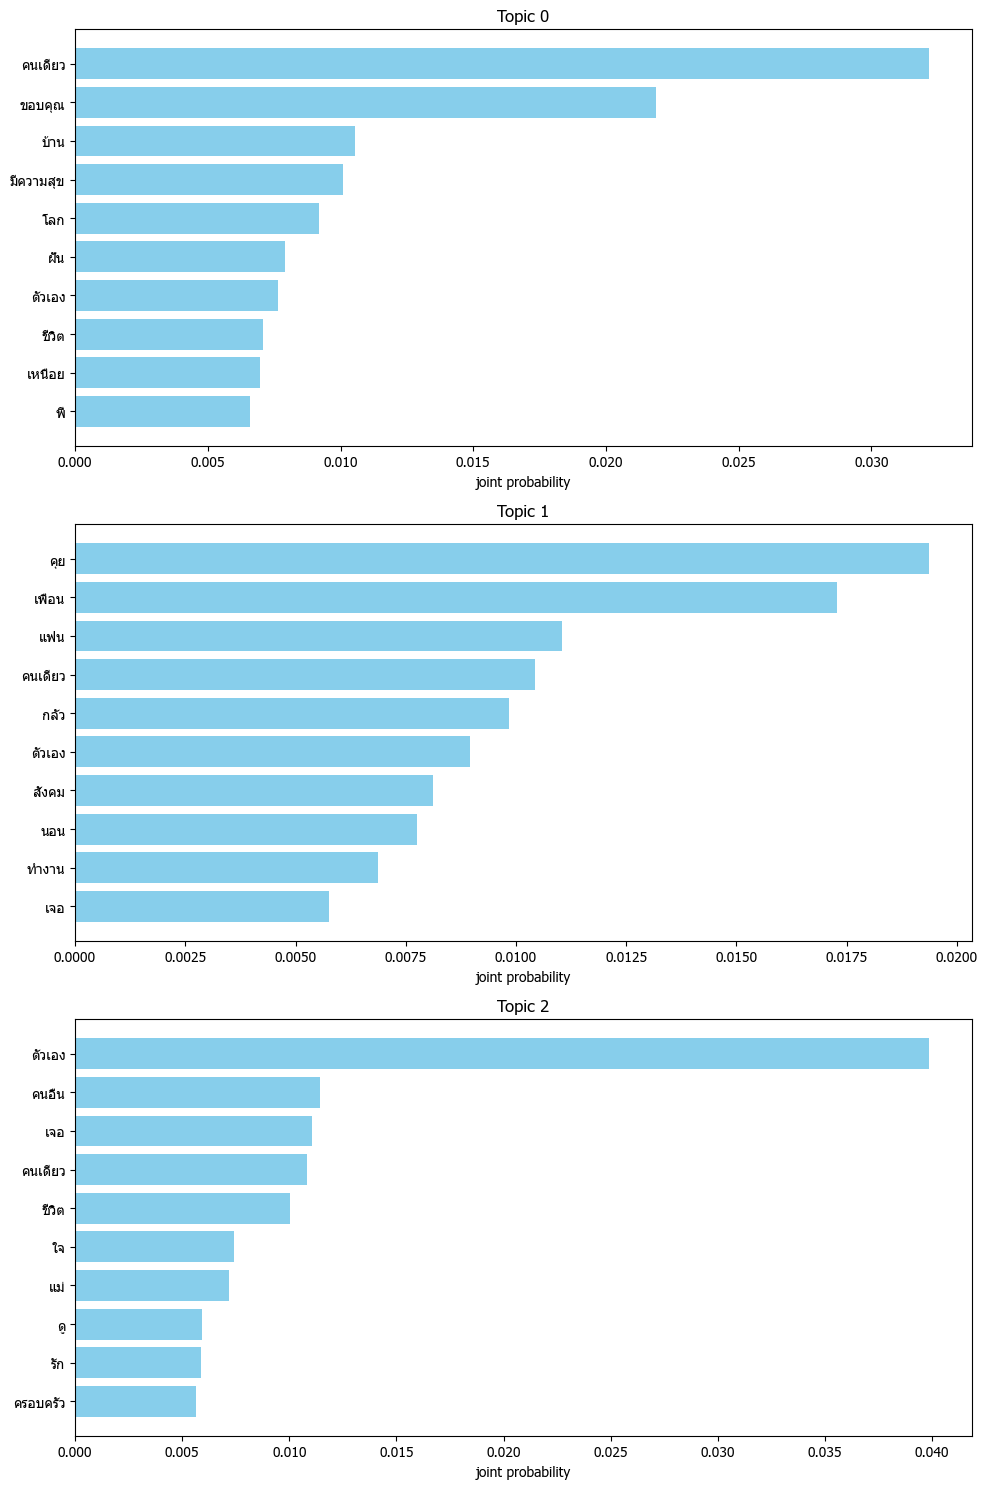

In [95]:
# Set font to one that supports Thai characters
plt.rcParams['font.family'] = 'Tahoma'

def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('joint probability')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)

## Non suicide ideation topical modeling

In [84]:
## create vocab <> ID dictionary
dictionary = Dictionary(non_suicide_ideation_texts) 

## create bag of words of each document
corpus = [dictionary.doc2bow(text) for text in non_suicide_ideation_texts]

num_topics = 3

## instantiation
lda = LdaModel(corpus, num_topics=num_topics)

## show top 20 words of all topics
for topic_no in range(num_topics):
    print(f"---------- TOPIC {topic_no} ----------")
    top20 = [dictionary[index] for index, prob in lda.get_topic_terms(topic_no, topn=20)]
    print(' | '.join(top20), '\n')

---------- TOPIC 0 ----------
คนเดียว | ขอบคุณ | บ้าน | มีความสุข | โลก | ฝัน | ตัวเอง | ชีวิต | เหนื่อย | พี่ | ความสุข | ดู | งาน | คุย | ใช้ชีวิต | สบายใจ | ทำงาน | ตอน | เจอ | หมอ 

---------- TOPIC 1 ----------
คุย | เพื่อน | แฟน | คนเดียว | กลัว | ตัวเอง | สังคม | นอน | ทำงาน | เจอ | เบื่อ | ที่จะ | ดู | about | invalid | zCSafez | ตื่น | เล่น | งาน | หา 

---------- TOPIC 2 ----------
ตัวเอง | คนอื่น | เจอ | คนเดียว | ชีวิต | ใจ | แม่ | ดู | รัก | ครอบครัว | ร้องไห้ | คลิป | ความรู้สึก | ความคิด | หา | ออกมา | เหนื่อย | เบื่อ | เศร้า | ลูก 



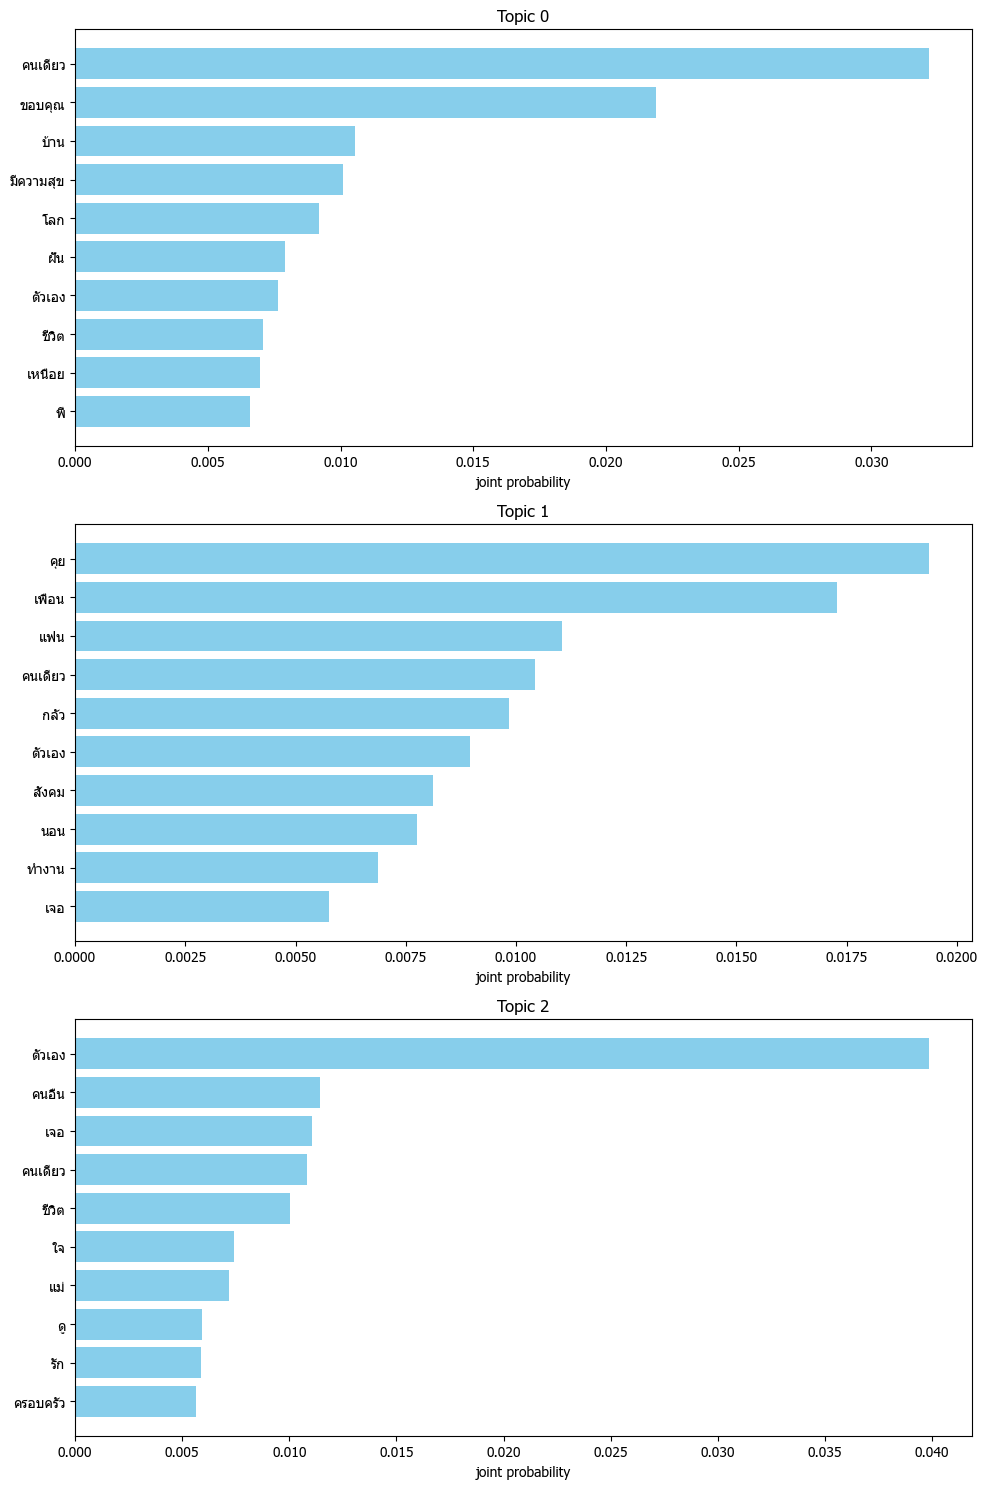

In [96]:
# Set font to one that supports Thai characters
plt.rcParams['font.family'] = 'Tahoma'

def plot_bar_charts_for_topics(lda_model, dictionary, num_topics=3, num_words=10):
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 5))

    for topic_no, ax in enumerate(axes):
        top_words = lda_model.get_topic_terms(topic_no, topn=num_words)
        topic_words = [(dictionary[index], prob) for index, prob in top_words]
        words, frequencies = zip(*topic_words)

        ax.barh(words, frequencies, color='skyblue')
        ax.set_title(f'Topic {topic_no}')
        ax.set_xlabel('joint probability')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# Example of using the function
plot_bar_charts_for_topics(lda, dictionary, num_topics=3, num_words=10)